In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import gpytorch

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
-0.17008563393804
-0.17008722229948095
-0.17008881017297656
-0.1700903942476099
-0.17009198114620444
-0.1700935656654431
-0.17009515017164875
-0.17009673560670807
-0.17009831913727222
-0.17009990218008267
-0.17010148615042045
-0.17010306633113348
-0.17010464791072444
-0.17010622711800055
-0.17010780772226763
-0.17010938783830992
-0.1701109660529017
-0.170112545192672
-0.1701141205516257
-0.17011569683660344
-0.1701172731012061
-0.170118848877881
-0.17012042416653075
-0.1701219970914966
-0.17012356999451667
-0.17012514194602524
-0.17012671387445397
-0.17012828672436212
-0.170129855805747
-0.17013142440103798
-0.1701329943797294
-0.1701345620017682
-0.170136127730168
-0.1701376948398849
-0.17013926100261553
-0.17014082527259014
-0.1701423909210598
-0.1701439542183343
-0.17014551562444435
-0.17014707981172553
-0.1701486402457745
-0.1701502015983189


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


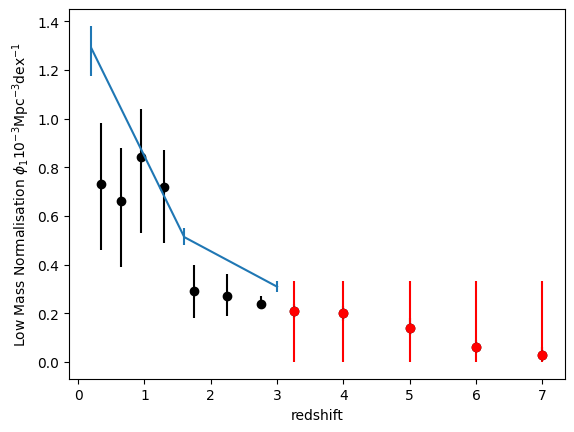

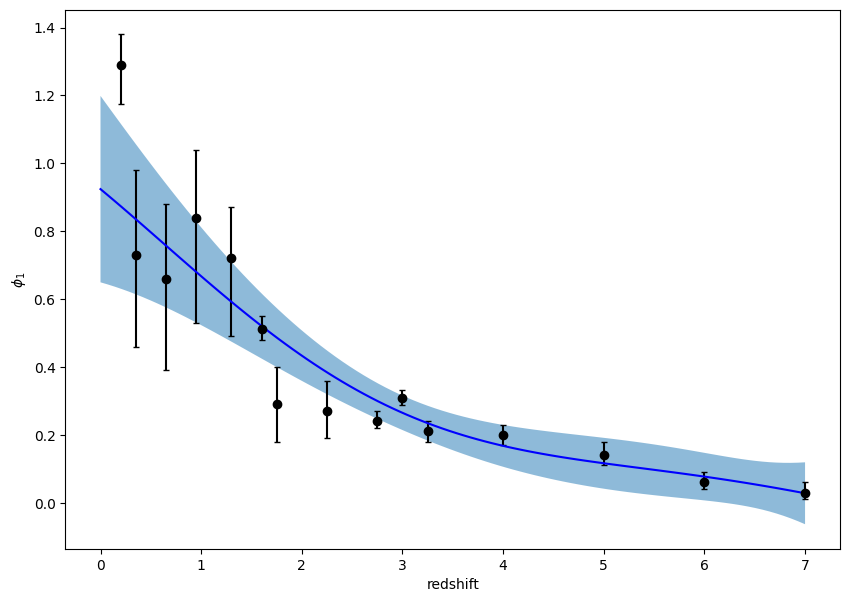

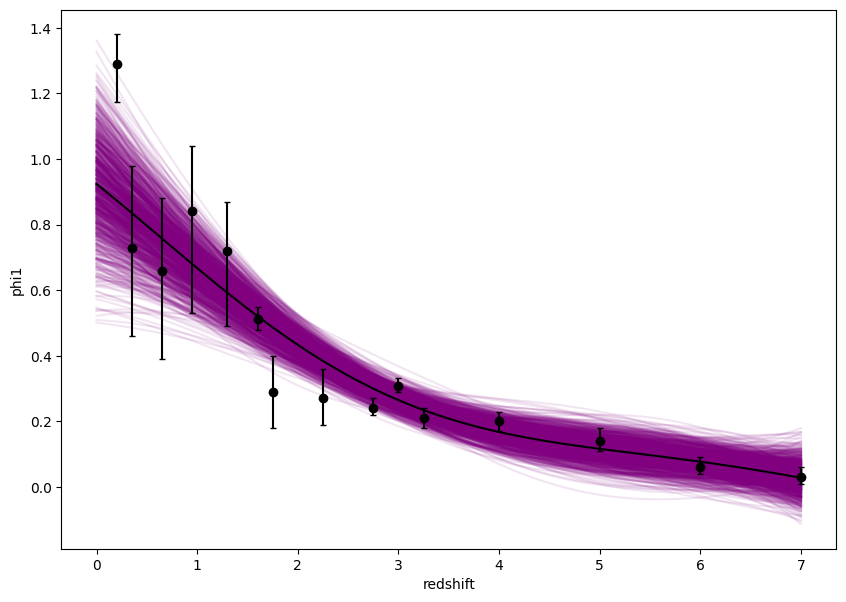

In [2]:
#assumption: declining normalisations with redshift
#little data above z>3, need to be open to having more galaxies at higher redshift due to results from jwst
#lhood or just use mean? if lhood, what width?? maybe just mean, assume small intrinsic scatter
#means are made up, problem?maybe using existing weaver points as mean...
#if have a gp for each, miss correlations between schecter parameters...

weaver_low_mass_norm_val = np.array([0.73, 0.66, 0.84, 0.72, 0.29, 0.27, 0.24, 0.21, 0.20, 0.14, 0.06, 0.03])
weaver_low_mass_norm_errl = np.array([0.27, 0.27, 0.31, 0.23, 0.11, 0.08, 0.02, 0.03, 0.03, 0.03, 0.02, 0.02])
weaver_low_mass_norm_errh = np.array([0.25, 0.22, 0.20, 0.15, 0.11, 0.09, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03])
weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2
plt.errorbar(weaver_redshift_midpoint, weaver_low_mass_norm_val, yerr=[weaver_low_mass_norm_errl, weaver_low_mass_norm_errh], fmt='ko')

log_cont_low_mass_norm_val = np.array([-2.89, -3.29, -3.51])
cont_low_mass_norm_val = (10**log_cont_low_mass_norm_val)*1000
cont_low_mass_norm_log_errl = np.array([0.04, 0.03, 0.03])
cont_low_mass_norm_log_errh = np.array([0.03, 0.03, 0.03])
cont_low_mass_norm_errl = cont_low_mass_norm_val - (10**(log_cont_low_mass_norm_val - cont_low_mass_norm_log_errl))*1000
cont_low_mass_norm_errh = (10**(log_cont_low_mass_norm_val + cont_low_mass_norm_log_errh))*1000 - cont_low_mass_norm_val
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

plt.errorbar(cont_redshift_anchor_points, cont_low_mass_norm_val, yerr=[cont_low_mass_norm_errl, cont_low_mass_norm_errh])

zg3_index = np.where(weaver_redshift_midpoint>3.0)[0]
zg3_redshifts = weaver_redshift_midpoint[zg3_index]
highz_low_mass_norm_val = weaver_low_mass_norm_val[zg3_index]
highz_low_mass_norm_errl = weaver_low_mass_norm_val[zg3_index]
high_zlow_mass_norm_errh = (cont_low_mass_norm_errh[-1] + cont_low_mass_norm_val[-1] - weaver_low_mass_norm_val[zg3_index])

plt.errorbar(zg3_redshifts, highz_low_mass_norm_val, yerr=[highz_low_mass_norm_errl, high_zlow_mass_norm_errh], fmt='ro')


plt.ylabel("Low Mass Normalisation $\phi_{1} 10^{-3}\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}$")
plt.xlabel("redshift")

train_phi1 = torch.from_numpy(np.concatenate((weaver_low_mass_norm_val, cont_low_mass_norm_val)))
train_phi1_errl = torch.from_numpy(np.concatenate((weaver_low_mass_norm_errl, cont_low_mass_norm_errl)))
train_phi1_errh = torch.from_numpy(np.concatenate((weaver_low_mass_norm_errh, cont_low_mass_norm_errh)))
train_phi1_errs = train_phi1_errl + train_phi1_errh
train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint, cont_redshift_anchor_points)))

sorted_redshift_inds = train_redshift.argsort()[:]
sorted_train_phi1 = train_phi1[sorted_redshift_inds]
sorted_train_phi1_errl = train_phi1_errl[sorted_redshift_inds]
sorted_train_phi1_errh = train_phi1_errh[sorted_redshift_inds]
sorted_train_phi1_errs = sorted_train_phi1_errl + sorted_train_phi1_errh
sorted_train_redshift = train_redshift[sorted_redshift_inds]
mean = np.interp(np.linspace(0, 7.0, 100), sorted_train_redshift, sorted_train_phi1)

#plt.plot(np.linspace(0, 7.0, 100), mean)

class PHI1Model(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood):
        super(PHI1Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.GreaterThan(3.0)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.square(sorted_train_phi1_errs), learn_additional_noise=False, noise_constraint=gpytorch.constraints.GreaterThan(0.0))
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.0))
model = PHI1Model(sorted_train_redshift, sorted_train_phi1, likelihood)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

training_iter = 10000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(sorted_train_redshift)
    # Calc loss and backprop gradients
    loss = -mll(output, sorted_train_phi1)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #i + 1, training_iter, loss.item(),
    print(loss.item())
        #model.likelihood.noise.item()
    #))
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 7.0, 100)

f_preds = model(test_x)
#y_preds = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_phi1.numpy(), yerr=[sorted_train_phi1_errl, sorted_train_phi1_errh], fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean + mean*0, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower+mean*0, upper+mean*0, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("$\phi_{1}$")

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 1000
    for sample in range(nsamples):
        f_sample = f_preds.sample()
        #if((f_sample > 0.0).all()):
        ax.plot(test_x, f_sample+mean*0, c='purple', alpha=0.1)
    ax.plot(test_x, f_preds.mean+mean*0, zorder=1000, ls='-', c='k')
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_phi1.numpy(), yerr=[sorted_train_phi1_errl, sorted_train_phi1_errh], fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("phi1")

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
2.0677265774171327
2.06768928314924
2.0676520014719415
2.067614725718012
2.0675774492308534
2.0675402264110647
2.067502927332944
2.067465668614305
2.06742842910682
2.0673911822253097
2.0673539134814707
2.067316719491838
2.067279462577852
2.0672422393600534
2.0672049942762274
2.0671677895111165
2.0671305496259293
2.0670933632975137
2.067056176248686
2.0670189951015536
2.066981785464702
2.066944581732999
2.066907424896622
2.0668702673462587
2.066833081313084
2.0667959421540467
2.066758774510392
2.0667216061640303
2.066684484670629
2.0666473690601492
2.066610218385368
2.06657308018619
2.066535988806512
2.0664988557916155
2.0664617418165268
2.0664246614875563
2.0663875592621643
2.0663504906792727
2.0663133592979204
2.0662763090244494
2.0662392646138494
2.066202150856194
2.0661651247312736
2.0661280635881556
2.066091049174826
2.066053999751987
2.06601

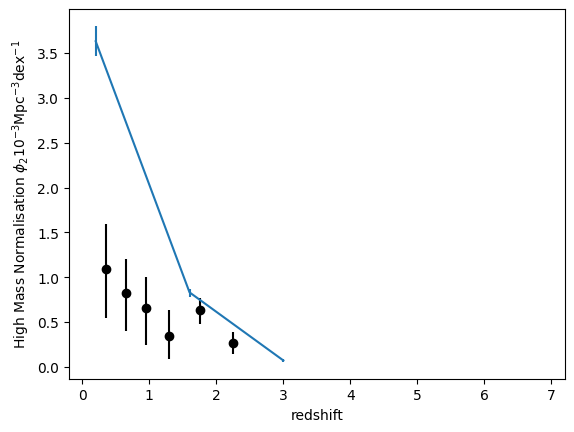

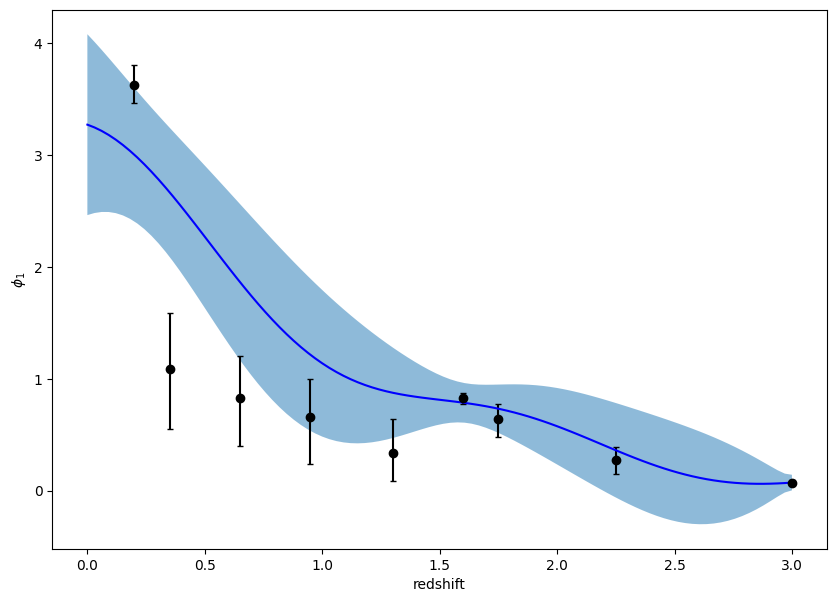

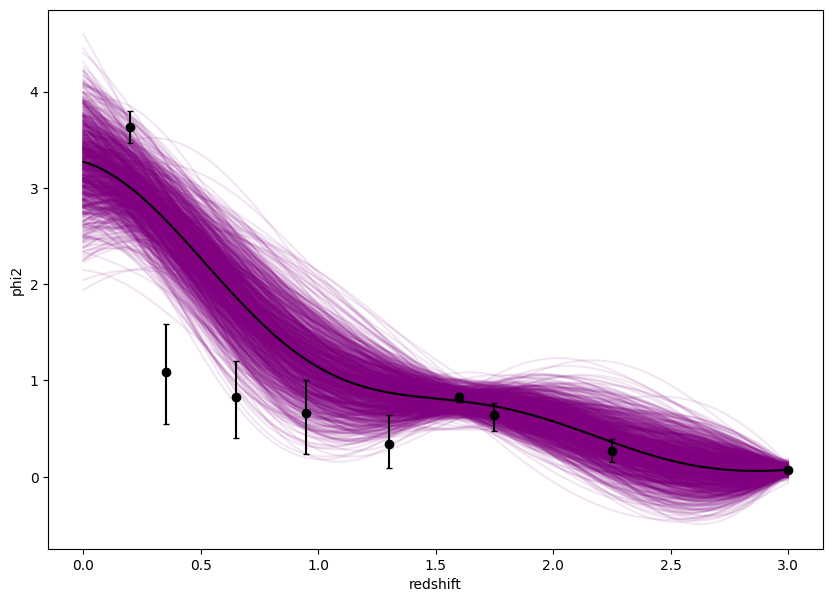

In [3]:
#it seems like weaver switiches to single shcecter function beyond z=3

weaver_high_mass_norm_val = np.array([1.09, 0.83, 0.66, 0.34, 0.64, 0.27])
weaver_high_mass_norm_errl = np.array([0.54, 0.43, 0.42, 0.25, 0.16, 0.12])
weaver_high_mass_norm_errh = np.array([0.5, 0.37, 0.34, 0.30, 0.13, 0.12])
weaver_redshift_lower_bin_edge_lowz = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0])
weaver_redshift_upper_bin_edge_lowz = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5])
weaver_redshift_midpoint_lowz = (weaver_redshift_lower_bin_edge_lowz + weaver_redshift_upper_bin_edge_lowz)/2
plt.errorbar(weaver_redshift_midpoint_lowz, weaver_high_mass_norm_val, yerr=[weaver_high_mass_norm_errl, weaver_high_mass_norm_errh], fmt='ko')

log_cont_high_mass_norm_val = np.array([-2.44, -3.08, -4.14])
cont_high_mass_norm_val = (10**log_cont_high_mass_norm_val)*1000
cont_high_mass_norm_log_errl = np.array([0.02, 0.03, 0.11])
cont_high_mass_norm_log_errh = np.array([0.02, 0.02, 0.10])
cont_high_mass_norm_errl = cont_high_mass_norm_val - (10**(log_cont_high_mass_norm_val - cont_high_mass_norm_log_errl))*1000
cont_high_mass_norm_errh = (10**(log_cont_high_mass_norm_val + cont_high_mass_norm_log_errh))*1000 - cont_high_mass_norm_val
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

plt.errorbar(cont_redshift_anchor_points, cont_high_mass_norm_val, yerr=[cont_high_mass_norm_errl, cont_high_mass_norm_errh])

plt.ylabel("High Mass Normalisation $\phi_{2} 10^{-3}\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}$")
plt.xlabel("redshift")
plt.xlim(-0.2, 7.2)

train_phi2 = torch.from_numpy(np.concatenate((weaver_high_mass_norm_val, cont_high_mass_norm_val)))
train_phi2_errl = torch.from_numpy(np.concatenate((weaver_high_mass_norm_errl, cont_high_mass_norm_errl)))
train_phi2_errh = torch.from_numpy(np.concatenate((weaver_high_mass_norm_errh, cont_high_mass_norm_errh)))
train_phi2_errs = train_phi2_errl + train_phi2_errh
train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint_lowz, cont_redshift_anchor_points)))

sorted_redshift_inds = train_redshift.argsort()[:]
sorted_train_phi2 = train_phi2[sorted_redshift_inds]
sorted_train_phi2_errl = train_phi2_errl[sorted_redshift_inds]
sorted_train_phi2_errh = train_phi2_errh[sorted_redshift_inds]
sorted_train_phi2_errs = sorted_train_phi2_errl + sorted_train_phi2_errh
sorted_train_redshift = train_redshift[sorted_redshift_inds]
#mean = np.interp(np.linspace(0, 7.0, 100), sorted_train_redshift, sorted_train_phi2)

#plt.plot(np.linspace(0, 7.0, 100), mean)

class PHI2Model(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood):
        super(PHI2Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.GreaterThan(0.5)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.square(sorted_train_phi2_errs), learn_additional_noise=False, noise_constraint=gpytorch.constraints.GreaterThan(0.0))
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.0))
model = PHI2Model(sorted_train_redshift, sorted_train_phi2, likelihood)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

training_iter = 10000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(sorted_train_redshift)
    # Calc loss and backprop gradients
    loss = -mll(output, sorted_train_phi2)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #i + 1, training_iter, loss.item(),
    print(loss.item())
        #model.likelihood.noise.item()
    #))
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 3.0, 100)

f_preds = model(test_x)
#y_preds = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_phi2.numpy(), yerr=[sorted_train_phi2_errl, sorted_train_phi2_errh], fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("$\phi_{1}$")

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 1000
    for sample in range(nsamples):
        f_sample = f_preds.sample()
        #if((f_sample > 0.0).all()):
        ax.plot(test_x, f_sample, c='purple', alpha=0.1)
    ax.plot(test_x, f_preds.mean, zorder=1000, ls='-', c='k')
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_phi2.numpy(), yerr=[sorted_train_phi2_errl, sorted_train_phi2_errh], fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("phi2")

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
-0.08802133598292675
-0.08806430406202245
-0.08810718315365247
-0.08815005844336442
-0.08819301510645979
-0.08823587423742711
-0.08827882329944643
-0.08832169194392302
-0.08836463340406944
-0.08840756252224947
-0.08845050493049496
-0.08849334130642757
-0.08853619096732099
-0.08857910492418396
-0.08862203215080472
-0.08866493853308235
-0.08870785817495523
-0.08875076550584601
-0.08879357539834973
-0.08883647516532799
-0.08887937114961098
-0.08892226335266488
-0.08896515177586402
-0.0890080279226608
-0.08905090879372987
-0.08909377739776
-0.08913665072240112
-0.08917951178932716
-0.08922229245969705
-0.08926513751922253
-0.08930808088244173
-0.08935092689556055
-0.0893937691495894
-0.0894366927470647
-0.08947952748470733
-0.08952235846753709
-0.08956518569696913
-0.08960800072179526
-0.0896509055406496
-0.08969371307300816
-0.08973651686414179
-0.0

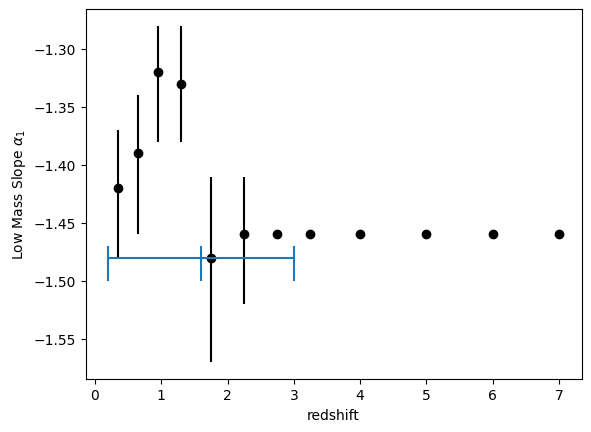

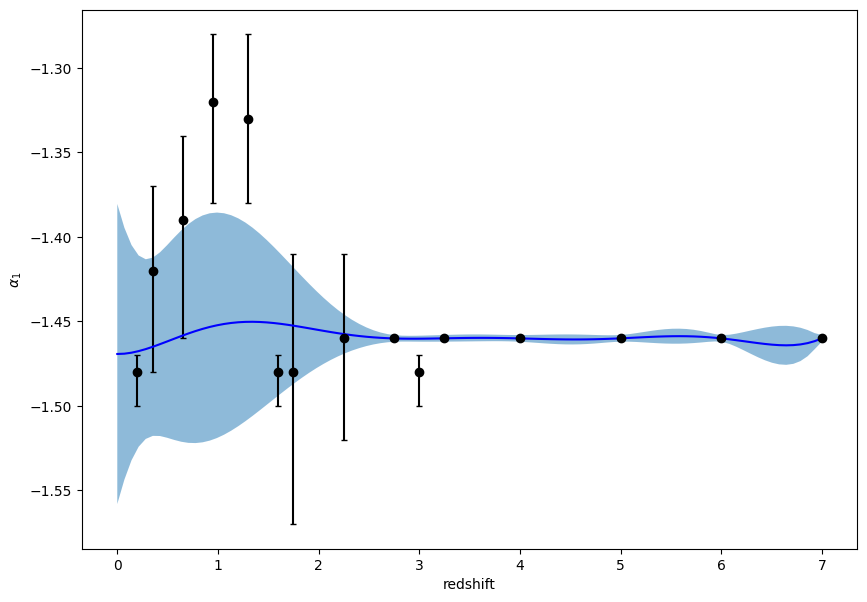

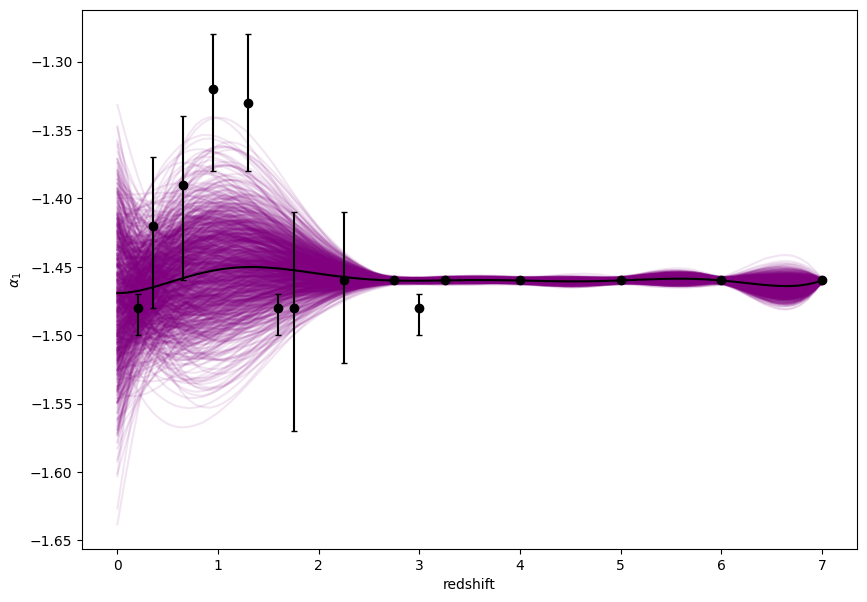

In [4]:
#slope fixed at z>2.5!!!!

weaver_alpha_low_mass_norm_val = np.array([-1.42, -1.39, -1.32, -1.33, -1.48, -1.46, -1.46, -1.46, -1.46, -1.46, -1.46, -1.46,])
weaver_alpha_low_mass_norm_errl = np.array([0.06, 0.07, 0.06, 0.05, 0.09, 0.06, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6])
weaver_alpha_low_mass_norm_errh = np.array([0.05, 0.05, 0.04, 0.05, 0.07, 0.05, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6])
weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2
plt.errorbar(weaver_redshift_midpoint, weaver_alpha_low_mass_norm_val, yerr=[weaver_alpha_low_mass_norm_errl, weaver_alpha_low_mass_norm_errh], fmt='ko')

cont_alpha_low_mass_norm_val = np.array([-1.48, -1.48, -1.48])
cont_alpha_low_mass_norm_errl = np.array([0.02, 0.02, 0.02])
cont_alpha_low_mass_norm_errh = np.array([0.01, 0.01, 0.01])
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])
plt.errorbar(cont_redshift_anchor_points, cont_alpha_low_mass_norm_val, yerr=[cont_alpha_low_mass_norm_errl, cont_alpha_low_mass_norm_errh])

plt.ylabel("Low Mass Slope $\\alpha_{1}$")
plt.xlabel("redshift")


train_alpha1 = torch.from_numpy(np.concatenate((weaver_alpha_low_mass_norm_val, cont_alpha_low_mass_norm_val)))
train_alpha1_errl = torch.from_numpy(np.concatenate((weaver_alpha_low_mass_norm_errl, cont_alpha_low_mass_norm_errl)))
train_alpha1_errh = torch.from_numpy(np.concatenate((weaver_alpha_low_mass_norm_errh, cont_alpha_low_mass_norm_errh)))
train_alpha1_errs = train_alpha1_errl + train_alpha1_errh
train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint, cont_redshift_anchor_points)))

sorted_redshift_inds = train_redshift.argsort()[:]
sorted_train_alpha1 = train_alpha1[sorted_redshift_inds]
sorted_train_alpha1_errl = train_alpha1_errl[sorted_redshift_inds]
sorted_train_alpha1_errh = train_alpha1_errh[sorted_redshift_inds]
sorted_train_alpha1_errs = sorted_train_alpha1_errl + sorted_train_alpha1_errh
sorted_train_redshift = train_redshift[sorted_redshift_inds]
#plt.plot(np.linspace(0, 7.0, 100), mean)

class ALPHA1Model(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood):
        super(ALPHA1Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.GreaterThan(0.5)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.square(sorted_train_alpha1_errs), learn_additional_noise=False, noise_constraint=gpytorch.constraints.GreaterThan(0.0))
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.0))
model = ALPHA1Model(sorted_train_redshift, sorted_train_alpha1, likelihood)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

training_iter = 10000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(sorted_train_redshift)
    # Calc loss and backprop gradients
    loss = -mll(output, sorted_train_alpha1)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #i + 1, training_iter, loss.item(),
    print(loss.item())
        #model.likelihood.noise.item()
    #))
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 7.0, 100)

f_preds = model(test_x)
#y_preds = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_alpha1.numpy(), yerr=[sorted_train_alpha1_errl, sorted_train_alpha1_errh], fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("$\\alpha_{1}$")

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 1000
    for sample in range(nsamples):
        f_sample = f_preds.sample()
        #if((f_sample > 0.0).all()):
        ax.plot(test_x, f_sample, c='purple', alpha=0.1)
    ax.plot(test_x, f_preds.mean, zorder=1000, ls='-', c='k')
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_alpha1.numpy(), yerr=[sorted_train_alpha1_errl, sorted_train_alpha1_errh], fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("$\\alpha_{1}$")


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
0.8444640316034925
0.8444474022405509
0.8444307858777141
0.8444141820172034
0.8443975510318276
0.844380933045723
0.8443643140235957
0.8443476949551036
0.8443310748521997
0.8443144411611967
0.8442978069285377
0.8442811987429625
0.8442645634272427
0.844247954159518
0.8442313308120055
0.8442147069237917
0.8441980824947746
0.8441814444709751
0.8441648189593113
0.8441482064445026
0.8441315663125516
0.844114952714867
0.8440983250379759
0.8440816968195661
0.8440650680595356
0.8440484387577822
0.8440318089142042
0.8440151780533438
0.8439985606631127
0.8439819291941814
0.843965296710387
0.8439486641577959
0.8439320441276518
0.8439154104908185
0.8438987763113438
0.8438821546562135
0.8438655058568838
0.8438488831183386
0.8438322463035604
0.8438156224819271
0.8437989850477496
0.8437823466075814
0.8437657076257737
0.8437490816360078
0.8437324420303507
0.84371

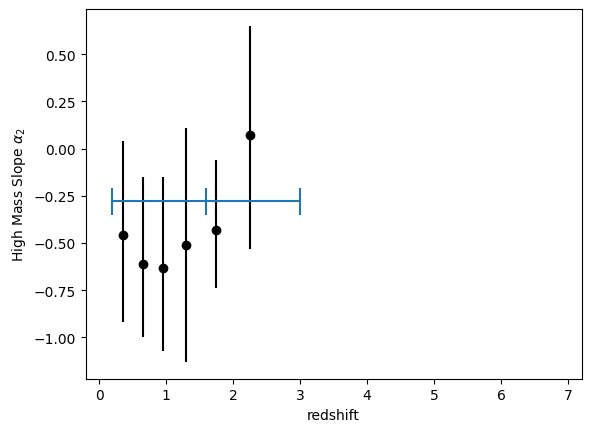

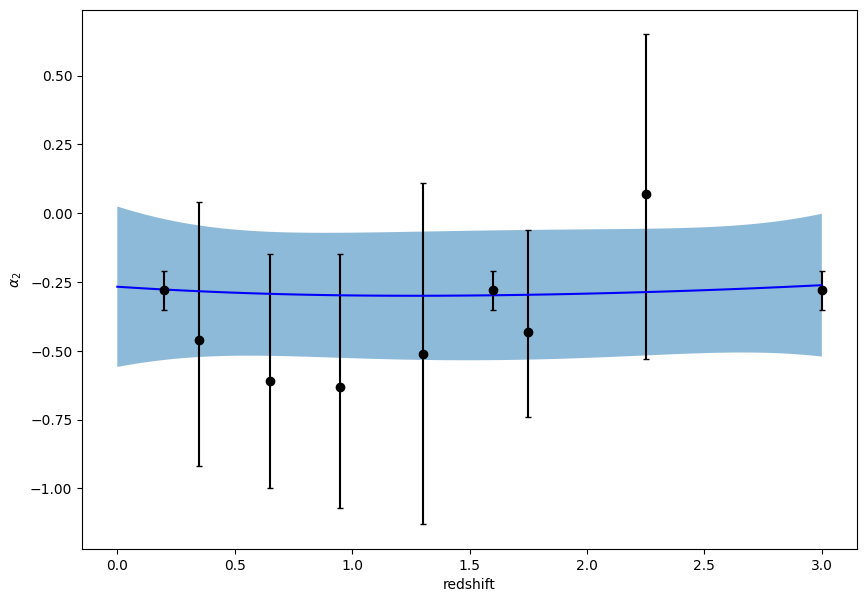

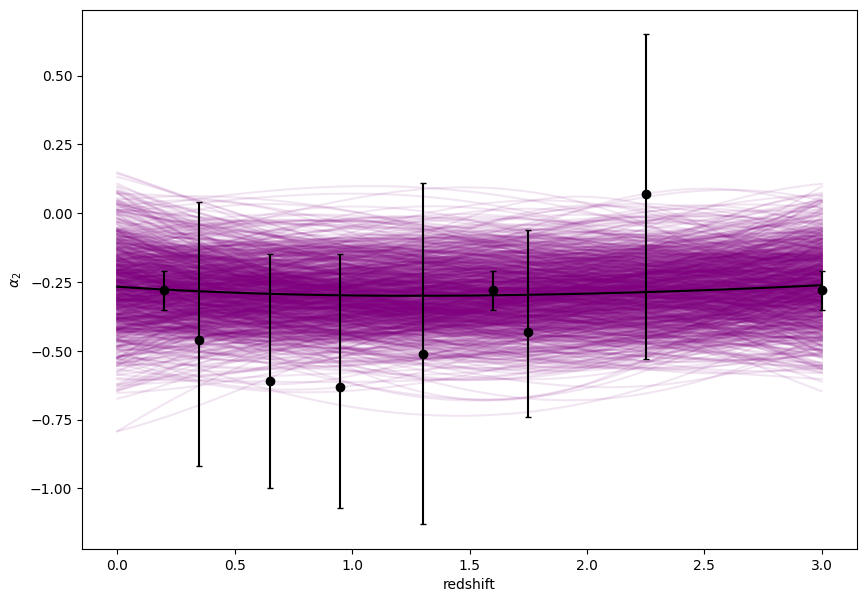

In [5]:
weaver_alpha_high_mass_norm_val = np.array([-0.46, -0.61, -0.63, -0.51, -0.43, 0.07])
weaver_alpha_high_mass_norm_errl = np.array([0.46, 0.39, 0.44, 0.62, 0.31, 0.60])
weaver_alpha_high_mass_norm_errh = np.array([0.5, 0.46, 0.48, 0.62, 0.37, 0.58])
weaver_redshift_lower_bin_edge_lowz = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0])
weaver_redshift_upper_bin_edge_lowz = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5])
weaver_redshift_midpoint_lowz = (weaver_redshift_lower_bin_edge_lowz + weaver_redshift_upper_bin_edge_lowz)/2
plt.errorbar(weaver_redshift_midpoint_lowz, weaver_alpha_high_mass_norm_val, yerr=[weaver_alpha_high_mass_norm_errl, weaver_alpha_high_mass_norm_errh], fmt='ko')


cont_alpha_high_mass_norm_val = np.array([-0.28, -0.28, -0.28])
cont_alpha_high_mass_norm_errl = np.array([0.07, 0.07, 0.07])
cont_alpha_high_mass_norm_errh = np.array([0.07, 0.07, 0.07])
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])
plt.errorbar(cont_redshift_anchor_points, cont_alpha_high_mass_norm_val, yerr=[cont_alpha_high_mass_norm_errl, cont_alpha_high_mass_norm_errh])

plt.ylabel("High Mass Slope $\\alpha_{2}$")
plt.xlabel("redshift")
plt.xlim(-0.2, 7.2)


train_alpha2 = torch.from_numpy(np.concatenate((weaver_alpha_high_mass_norm_val, cont_alpha_high_mass_norm_val)))
train_alpha2_errl = torch.from_numpy(np.concatenate((weaver_alpha_high_mass_norm_errl, cont_alpha_high_mass_norm_errl)))
train_alpha2_errh = torch.from_numpy(np.concatenate((weaver_alpha_high_mass_norm_errh, cont_alpha_high_mass_norm_errh)))
train_alpha2_errs = train_alpha2_errl + train_alpha2_errh
train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint_lowz, cont_redshift_anchor_points)))

sorted_redshift_inds = train_redshift.argsort()[:]
sorted_train_alpha2 = train_alpha2[sorted_redshift_inds]
sorted_train_alpha2_errl = train_alpha2_errl[sorted_redshift_inds]
sorted_train_alpha2_errh = train_alpha2_errh[sorted_redshift_inds]
sorted_train_alpha2_errs = sorted_train_alpha2_errl + sorted_train_alpha2_errh
sorted_train_redshift = train_redshift[sorted_redshift_inds]
#plt.plot(np.linspace(0, 7.0, 100), mean)

class ALPHA2Model(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood):
        super(ALPHA2Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.GreaterThan(0.5)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.square(sorted_train_alpha2_errs), learn_additional_noise=False, noise_constraint=gpytorch.constraints.GreaterThan(0.0))
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.0))
model = ALPHA2Model(sorted_train_redshift, sorted_train_alpha2, likelihood)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

training_iter = 10000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(sorted_train_redshift)
    # Calc loss and backprop gradients
    loss = -mll(output, sorted_train_alpha2)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #i + 1, training_iter, loss.item(),
    print(loss.item())
        #model.likelihood.noise.item()
    #))
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 3.0, 100)

f_preds = model(test_x)
#y_preds = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_alpha2.numpy(), yerr=[sorted_train_alpha2_errl, sorted_train_alpha2_errh], fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("$\\alpha_{2}$")

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 1000
    for sample in range(nsamples):
        f_sample = f_preds.sample()
        #if((f_sample > 0.0).all()):
        ax.plot(test_x, f_sample, c='purple', alpha=0.1)
    ax.plot(test_x, f_preds.mean, zorder=1000, ls='-', c='k')
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_alpha2.numpy(), yerr=[sorted_train_alpha2_errl, sorted_train_alpha2_errh], fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("$\\alpha_{2}$")



Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
8.155565037511106
8.154934316338771
8.154303685428557
8.15367339475377
8.153042944287812
8.152413522682581
8.151782563875724
8.15115238394277
8.150522294156337
8.149892294497183
8.149261696747567
8.148632815299306
8.148002397889556
8.147372758626844
8.146742521604017
8.146113062486066
8.145483693360783
8.144853976405752
8.144224787287767
8.143595688104853
8.142965991656864
8.142337072388106
8.141707556019213
8.14107881658782
8.140449480221152
8.139820920550399
8.139191764109155
8.138563384122323
8.137934407529723
8.137306207150145
8.13667809649477
8.136049389480553
8.135421458317529
8.134792930960252
8.134164493453401
8.133536831436087
8.132908573471246
8.132281090754985
8.131653012255594
8.131025023510903
8.130397809653495
8.129770000259484
8.129142280562762
8.128515335392285
8.127887794931585
8.12726102875661
8.126632982910944
8.12600639575623


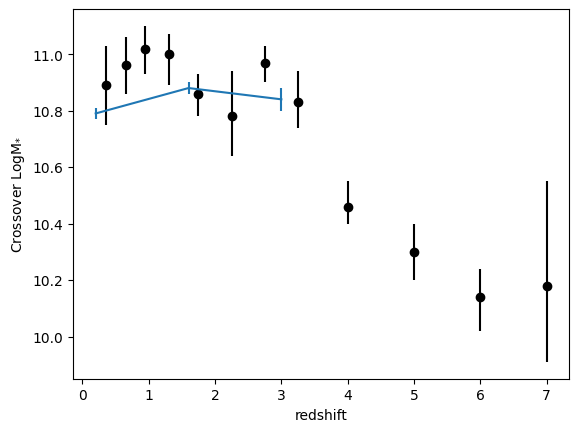

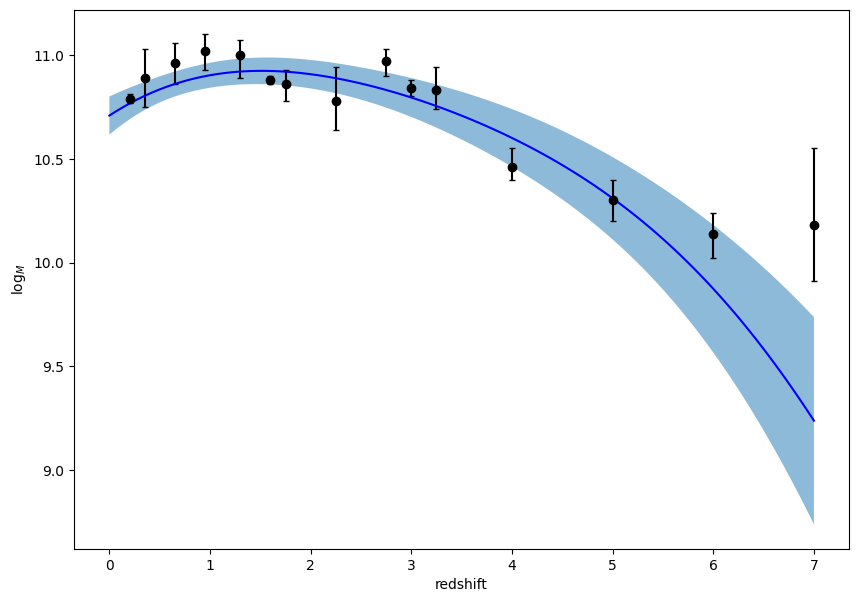

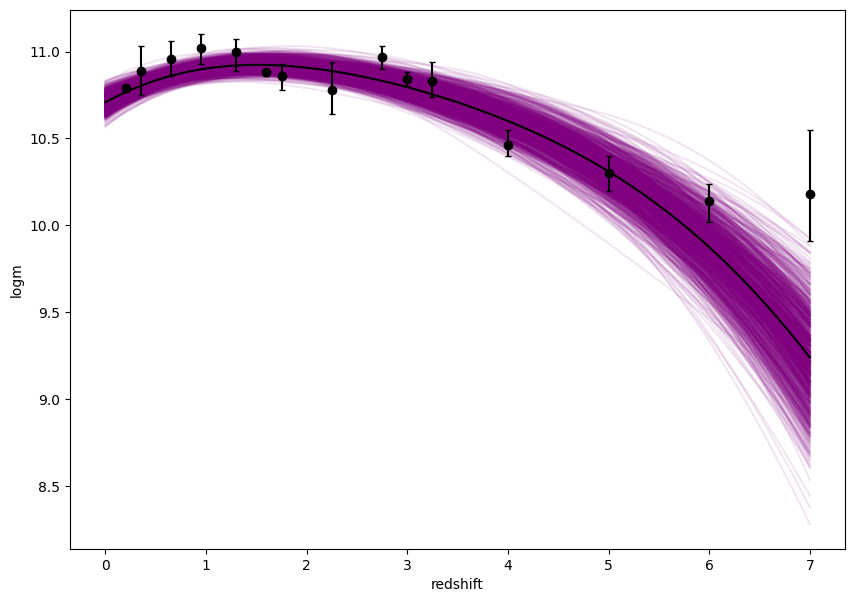

In [6]:
weaver_logm_val = np.array([10.89, 10.96, 11.02, 11.00, 10.86, 10.78, 10.97, 10.83, 10.46, 10.30, 10.14, 10.18])
weaver_logm_errl = np.array([0.14, 0.10, 0.09, 0.11, 0.08, 0.14, 0.07, 0.09, 0.06, 0.10, 0.12, 0.27])
weaver_logm_errh = np.array([0.14, 0.10, 0.08, 0.07, 0.07, 0.16, 0.06, 0.11, 0.09, 0.10, 0.10, 0.37])
weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2
plt.errorbar(weaver_redshift_midpoint, weaver_logm_val, yerr=[weaver_logm_errl, weaver_logm_errh], fmt='ko')

cont_logm_val = np.array([10.79, 10.88, 10.84])
cont_logm_errl = np.array([0.02, 0.02, 0.04])
cont_logm_errh = np.array([0.02, 0.02, 0.04])
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])
plt.errorbar(cont_redshift_anchor_points, cont_logm_val, yerr=[cont_logm_errl, cont_logm_errh])

plt.ylabel("Crossover $\mathrm{LogM}_{*}$")
plt.xlabel("redshift")

train_logm = torch.from_numpy(np.concatenate((weaver_logm_val, cont_logm_val)))
train_logm_errl = torch.from_numpy(np.concatenate((weaver_logm_errl, cont_logm_errl)))
train_logm_errh = torch.from_numpy(np.concatenate((weaver_logm_errh, cont_logm_errh)))
train_logm_errs = train_logm_errl + train_logm_errh
train_redshift = torch.from_numpy(np.concatenate((weaver_redshift_midpoint, cont_redshift_anchor_points)))

sorted_redshift_inds = train_redshift.argsort()[:]
sorted_train_logm = train_logm[sorted_redshift_inds]
sorted_train_logm_errl = train_logm_errl[sorted_redshift_inds]
sorted_train_logm_errh = train_logm_errh[sorted_redshift_inds]
sorted_train_logm_errs = sorted_train_logm_errl + sorted_train_logm_errh
sorted_train_redshift = train_redshift[sorted_redshift_inds]

#plt.plot(np.linspace(0, 7.0, 100), mean)

class LOGMModel(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood):
        super(LOGMModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.GreaterThan(3.0)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.square(sorted_train_logm_errs), learn_additional_noise=False, noise_constraint=gpytorch.constraints.GreaterThan(0.0))
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.0))
model = LOGMModel(sorted_train_redshift, sorted_train_logm, likelihood)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

training_iter = 10000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(sorted_train_redshift)
    # Calc loss and backprop gradients
    loss = -mll(output, sorted_train_logm)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #i + 1, training_iter, loss.item(),
    print(loss.item())
        #model.likelihood.noise.item()
    #))
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 7.0, 100)

f_preds = model(test_x)
#y_preds = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_logm.numpy(), yerr=[sorted_train_logm_errl, sorted_train_logm_errh], fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("$\log_{M}$")

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 1000
    for sample in range(nsamples):
        f_sample = f_preds.sample()
        #if((f_sample > 0.0).all()):
        ax.plot(test_x, f_sample, c='purple', alpha=0.1)
    ax.plot(test_x, f_preds.mean, zorder=1000, ls='-', c='k')
    ax.errorbar(sorted_train_redshift.numpy(), sorted_train_logm.numpy(), yerr=[sorted_train_logm_errl, sorted_train_logm_errh], fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("logm")